# Evaluating the deep learning model on the dev set

## Import the necessary libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf

## Load dev set

In [31]:
dev_path = 'data/dev.csv'
dev_df = pd.read_csv(dev_path)

dev_df.head()

,premise,hypothesis,label
0,Mon Dieu!,This person is speaking English.,0
1,"He really shook up my whole mindset, Broker sa...","His mindset never changed, Broker said.",0
2,Patients were asked to place themselves on a r...,Most patients rated themselves as a 5 on the s...,1
3,I managed to pick-pocket someone next to the s...,I stole someone's wallet near the concession s...,1
4,Forty comments were received and considered pr...,The decisions regarding the issuance of the fi...,1


In [32]:
# Print rows with missing values or NaN
print(dev_df[dev_df.isnull().any(axis=1)])
print(dev_df[dev_df.isna().any(axis=1)])

# Replace missing values with an empty string
dev_df.fillna('', inplace=True)

                                                premise hypothesis  label
3126  Tony  Shoes (so Clinton will have Shoes and So...        NaN      1
3970                            Saint-Germain-des-Pr??s        NaN      1
                                                premise hypothesis  label
3126  Tony  Shoes (so Clinton will have Shoes and So...        NaN      1
3970                            Saint-Germain-des-Pr??s        NaN      1


## Load GloVe embeddings and create a dictionary

In [33]:
def load_glove_embeddings(embedding_path):
    print("Loading GloVe embeddings...")
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

In [34]:
# Define the function to convert sentences to vectors
# Same approach as in the previous notebook while training the model, from Bowman et al. (2015)
def sentence_embedding(sentence, embeddings_index):
    words = sentence.split()
    embedding_dim = next(iter(embeddings_index.values())).shape[0]
    sentence_embedding = np.zeros(embedding_dim)
    for word in words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            sentence_embedding += embedding_vector
    return (sentence_embedding + 1) / (len(words) + 1)

In [35]:
embedding_path = "./input/embeddings/glove.6B/glove.6B.300d.txt"
embeddings_index = load_glove_embeddings(embedding_path)

Loading GloVe embeddings...
Loaded 400001 word vectors.


## Load the deep learning model

In [36]:
model_path = "./models/deep_learning/model.keras"
model = tf.keras.models.load_model(model_path)

In [37]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 500)            │       300,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 400)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 300)            │       120,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,208 (9.87 MB)

 Trainable params: 862,402 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,724,806 (6.58 MB)

In [38]:
# Create sentence embeddings for the dev set
dev_premise_embeddings = [sentence_embedding(x, embeddings_index) for x in dev_df['premise']]
dev_hypothesis_embeddings = [sentence_embedding(x, embeddings_index) for x in dev_df['hypothesis']]

In [39]:
X_dev = np.hstack((np.array(dev_premise_embeddings), np.array(dev_hypothesis_embeddings)))
y_dev = dev_df['label']

# Get the predictions
y_dev_pred = model.predict(X_dev)
y_dev_pred = np.argmax(y_dev_pred, axis=1)

# Print the classification report
print(classification_report(y_dev, y_dev_pred))

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      3259
           1       0.65      0.64      0.65      3478

    accuracy                           0.64      6737
   macro avg       0.64      0.64      0.64      6737
weighted avg       0.64      0.64      0.64      6737



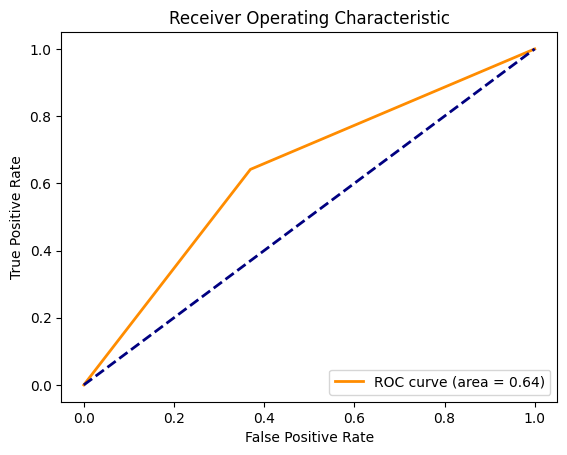

In [40]:
fpr, tpr, _ = roc_curve(y_dev, y_dev_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

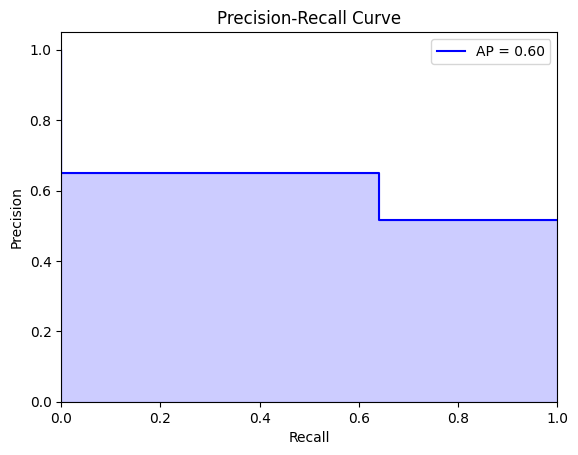

In [41]:
precision, recall, _ = precision_recall_curve(y_dev, y_dev_pred)
average_precision = average_precision_score(y_dev, y_dev_pred)

plt.figure()
plt.step(recall, precision, color='b', where='post', label=f'AP = {average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.show()

## Save the predictions

In [42]:
dev_pred = pd.DataFrame({'prediction': y_dev_pred})
dev_pred.to_csv('dev_predictions.csv', index=False)